In [53]:
import pandas  as pd #Data manipulation
from pymongo import MongoClient
import yaml
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# lib ML
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Importation des données

In [2]:
# Connection MongoDB
with open('config.yaml','r') as f:
    config = yaml.safe_load(f)

In [3]:
mg = config['MONGODB_TEST'] # Changer ici pour TEST/PROD
connexion = f"mongodb://{mg['ip']}:{mg['port']}"
client = MongoClient(connexion)
db = client[mg['client']]
collec = db[mg['db']]

In [4]:
df = pd.DataFrame(list(collec.find()))
#df = pd.read_csv('results.csv', encoding = "UTF-8")

In [5]:
"""
df = df[['job_clean','exp','clean_location','presence','remote','hybrid','annual_salary',
         'python', 'java','azure','aws','sql','excel', 'mak','ssis','anglais','git', 'docker',
         'agile','spark','contract']]
"""
df = df[['job_clean','exp','clean_location','annual_salary','contract']]

In [6]:
df.head()

,job_clean,exp,clean_location,annual_salary,contract
0,developpeur,1,clermont-ferrand,46000.0,
1,developpeur,1,france,85000.0,
2,developpeur,1,auvergne-rhone-alpes,100000.0,
3,developpeur,1,paris,0.0,
4,developpeur,1,molsheim,0.0,


In [7]:
df.shape

(1443, 5)

# Dataviz

In [8]:
"""
df.drop(
    ['java script',
     'Cobol',
     'cordova',
    'Bootstrap',
    'kibana',
    'db400',
    'nuxtjs',
    'rpgle',
    'webdesign',
    'windev',
    'apache hadoop',
    'Angular 12',
    'elastic search',
    'mean_salary',
    'min_salary',
    'monthly_salary']
,axis=1,inplace=True)
"""

"\ndf.drop(\n    ['java script',\n     'Cobol',\n     'cordova',\n    'Bootstrap',\n    'kibana',\n    'db400',\n    'nuxtjs',\n    'rpgle',\n    'webdesign',\n    'windev',\n    'apache hadoop',\n    'Angular 12',\n    'elastic search',\n    'mean_salary',\n    'min_salary',\n    'monthly_salary']\n,axis=1,inplace=True)\n"

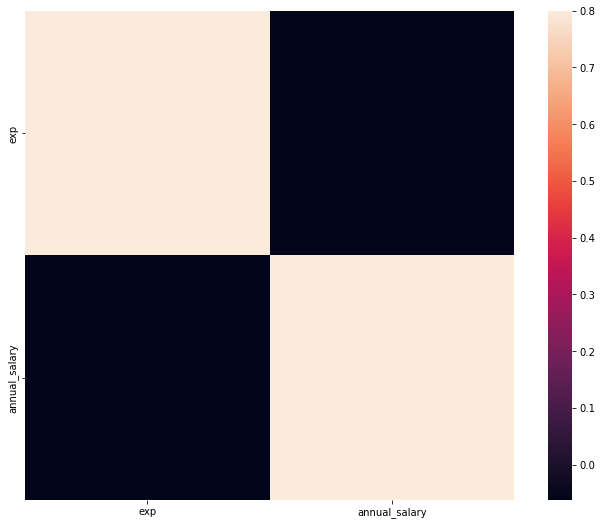

In [9]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [10]:
#df.corr()[df.corr() > .6]
cor_matrix = df.corr().abs()
#print(cor_matrix)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] < 0.6)]
df1 = df.drop(to_drop, axis=1)
print(df1.columns)

Index(['job_clean', 'exp', 'clean_location', 'contract'], dtype='object')


/tmp/ipykernel_26473/2502461082.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [11]:
df2 = df.filter(['_id', 'job_title', 'job_clean', 'contract', 'exp', 'company',
       'job_location', 'clean_location', 'salary', 'interval', 'summary',
       'post_date', 'clean_date', 'google analytic', ' r '])

In [12]:
df2.shape

(1443, 4)

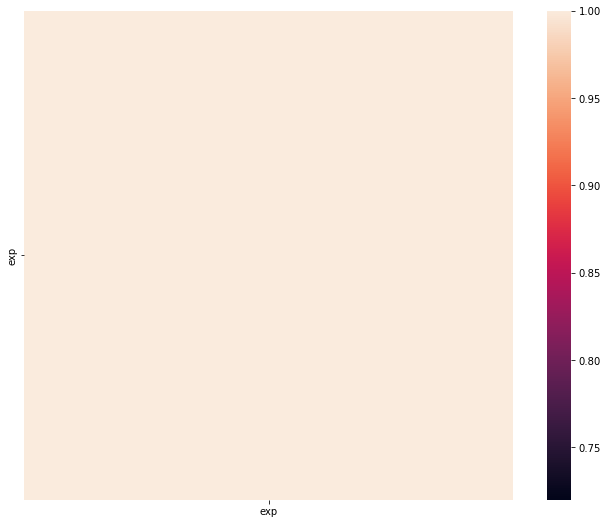

In [13]:
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# Preprocessing

In [14]:
# Imputation
#df['contract'] = df['annual_salary'] < 20000 = 'stage'

df[df['annual_salary'] < 20000]['contract'] = 'stage'
#df['contract'][df['annual_salary'] >= 20000] = 'cdi'

/tmp/ipykernel_26473/1082164631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['annual_salary'] < 20000]['contract'] = 'stage'


In [15]:
df['contract'][df['annual_salary'] < 20000] = 'stage'

In [16]:
df['annual_salary'] < 20000

0       False
1       False
2       False
3        True
4        True
        ...  
1438    False
1439     True
1440     True
1441     True
1442     True
Name: annual_salary, Length: 1443, dtype: bool

In [17]:
df['contract'] = np.where(df['annual_salary'] < 20000,'stage','cdi')
df['contract']

0         cdi
1         cdi
2         cdi
3       stage
4       stage
        ...  
1438      cdi
1439    stage
1440    stage
1441    stage
1442    stage
Name: contract, Length: 1443, dtype: object

In [18]:
#df.drop(['_id','summary,'], axis=1, inplace=True)
#df = df.filter(['job_clean','clean_location','annual_salary'])

In [19]:
df.head()

,job_clean,exp,clean_location,annual_salary,contract
0,developpeur,1,clermont-ferrand,46000.0,cdi
1,developpeur,1,france,85000.0,cdi
2,developpeur,1,auvergne-rhone-alpes,100000.0,cdi
3,developpeur,1,paris,0.0,stage
4,developpeur,1,molsheim,0.0,stage


In [20]:
df = df[df['annual_salary'] != 0]
#df[['bought_apples','bought_pears']].sum(axis=1) > 0

In [21]:
df

,job_clean,exp,clean_location,annual_salary,contract
0,developpeur,1,clermont-ferrand,46000.0,cdi
1,developpeur,1,france,85000.0,cdi
2,developpeur,1,auvergne-rhone-alpes,100000.0,cdi
7,developpeur,1,joue-les-tours,6000.0,stage
13,developpeur,1,antony,13200.0,stage
...,...,...,...,...,...
1404,business intelligence,1,toulouse,40000.0,cdi
1416,business intelligence,1,paris,8400.0,stage
1428,data analyst,1,paris,10956.0,stage
1435,business intelligence,1,toulouse,40000.0,cdi


In [22]:
df.isnull().sum(axis = 0)

job_clean         0
exp               0
clean_location    0
annual_salary     0
contract          0
dtype: int64

Colonne catégorie

In [23]:
#categorical_columns = ['clean_location','job_clean']

In [24]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [25]:
categorical_columns

Index(['job_clean', 'clean_location', 'contract'], dtype='object')

Features preprocessing

In [26]:
X = df.drop(columns=['annual_salary'])
X.head()

,job_clean,exp,clean_location,contract
0,developpeur,1,clermont-ferrand,cdi
1,developpeur,1,france,cdi
2,developpeur,1,auvergne-rhone-alpes,cdi
7,developpeur,1,joue-les-tours,stage
13,developpeur,1,antony,stage


In [27]:
y = df['annual_salary']
y.head()

0      46000.0
1      85000.0
2     100000.0
7       6000.0
13     13200.0
Name: annual_salary, dtype: float64

In [28]:
"""
class transformToPredict(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y =None):
        return self
    
    def transform(self, X, y =None):
        
        if not isinstance(X, pd.DataFrame):
            # Creation d'un dataframe
            dic = {'clean_location': X}
            df = pd.DataFrame(dic, index=[0]) 
        else:
            df = X.copy()
   
        return df
"""

"\nclass transformToPredict(BaseEstimator,TransformerMixin):\n    def __init__(self):\n        return None\n    \n    def fit(self, X, y =None):\n        return self\n    \n    def transform(self, X, y =None):\n        \n        if not isinstance(X, pd.DataFrame):\n            # Creation d'un dataframe\n            dic = {'clean_location': X}\n            df = pd.DataFrame(dic, index=[0]) \n        else:\n            df = X.copy()\n   \n        return df\n"

In [29]:
# 1er pipeline pour traitement du df
#transfo_to_df = Pipeline(steps=[
#    ('base', transformToPredict)
#])

In [30]:
transfo_cat = Pipeline(steps=[
    #('imputation', SimpleImputer(strategy='most_frequent')), Donnees manquantes ? a voir
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
])

In [31]:
#transfo_df = Pipeline(steps=[
#    ('scaling', MinMaxScaler())
#])

In [32]:
preparation = ColumnTransformer(
    transformers=[
        ('data_cat', transfo_cat , categorical_columns)
        #('data_df', transfo_df , all_columns)
    ])

# Model

In [66]:
#model = LinearRegression()
model = RandomForestRegressor(bootstrap=False)
pipe_model = Pipeline(steps=[
    #('base',transformToPredict()),
    ('preparation', preparation),
    ('model',model)])
pipe_model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['job_clean', 'clean_location', 'contract'], dtype='object'))])),
                ('model', RandomForestRegressor(bootstrap=False))])

# Traint test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #stratify=y

In [68]:
pipe_model.fit(X_train,y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['job_clean', 'clean_location', 'contract'], dtype='object'))])),
                ('model', RandomForestRegressor(bootstrap=False))])

# Model evaluation

In [69]:
pipe_model.score(X_train, y_train)

0.6935093751512029

# Metriques

In [50]:
#MSE
prediction = pipe_model.predict(X_test)
mean_squared_error(y_test, prediction)

print("RMSE :", round(np.sqrt(mean_squared_error(y_test, prediction)), 2))

RMSE : 14126.41


In [52]:
mae = mean_absolute_error(y_test, prediction)
print(mae)

10721.360332649803


In [39]:
#pipe_model.predict('Paris')

In [40]:
#dic = {'clean_location': 'Paris'}
#df_predict = pd.DataFrame(dic, index=[0])
#pipe_model.predict(df_predict)

Enregistrement du modele

In [41]:
#pickle.dump(pipe_model,open('model.pkl','wb'))